# Customer Segmentation & Revenue Growth Strategy

### Бизнес-задача:

Компания стремится увеличить доход и лояльность клиентов, оптимизируя маркетинговые кампании и улучшая персонализированные предложения. Для этого необходимо понять поведение разных групп покупателей: кто приносит основную выручку, кто повторно покупает, а кто потенциально может быть вовлечен в активные продажи.

### Цель проекта:

Сегментировать клиентскую базу с использованием RFM-метрик (Recency, Frequency, Monetary), выявить наиболее ценные и перспективные сегменты, а также разработать рекомендации для:
1) Увеличения повторных покупок.
2) Рост среднего чека.
3) Эффективного распределения маркетингового бюджета на разных группах клиентов для максимизации выручки.

# Описание данных

В нашем распоряжении следующие датасеты:

Структура customers.csv:
- customer_id - позаказный идентификатор пользователя
- customer_unique_id - уникальный идентификатор пользователя (аналог номера паспорта)
- customer_zip_code_prefix - почтовый индекс пользователя
- customer_city - город доставки пользователя
- customer_state -  штат доставки пользователя

Структура items:
- order_id - номер заказа
- order_item_id - порядковый номер, определяющий количество товаров, включенных в один и тот же заказ.
- product_id - уникальный идентификатор продукта
- seller_id - продавец
- shipping_limit_date - дата отгрузки
- price - цена
- freight_value - стоимость фрахта

Структура payments.csv:

- order_id — уникальный идентификатор заказа (номер чека)
- payment_sequential - номер платежа в заказе
- payment_type - тип оплаты
- payment_installments - кол-во платежей рассрочки
- payment_value - сумма платежа

т.е. один заказ может быть оплачен несколькими платежами и разными типами оплаты

Структура orders.csv:

- order_id — уникальный идентификатор заказа (номер чека)
- customer_id - позаказный идентификатор пользователя
- order_status - тип заказа
- order_purchase_timestamp - дата оплаты заказа
- order_approved_at - дата подтверждения заказа продавцом
- order_delivered_carrier_date - дата передачи заказа перевозчику
- order_delivered_customer_date - дата доставки (фактическая)
- order_estimated_delivery_date - дата доставки (плановая)


Структура products:

- product_id - уникальный идентификатор продукта
- product_category_name - наименование категории товара на испанском
- product_name_lenght - длинна наименования товара
- product_description_lenght - длина описания товара
- product_photos_qty - кол-во фото
- product_weight_g - вес в граммах
- product_length_cm -длина в см
- product_height_cm - высота в см
- product_width_cm - ширина в см

Структура categories:
    
- product_category_name - наименование категории товара на испанском
- product_category_name_english -  наименование категории товара на английском

# Подлючение библиотек, загрузка данных

In [39]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = lambda x: ('%.12f' % x).rstrip('0').rstrip('.')

# библиотеки визуализации:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from datetime import datetime

In [5]:
# import os
# os.getcwd()
# os.chdir('/home/alorozhkov/jup/Segmentation(rfm)/')

In [6]:
customers = pd.read_csv('customers.csv')
items = pd.read_csv('order_items.csv')
payments = pd.read_csv('order_payments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
categories = pd.read_csv('category_name.csv')

# Загрузка данных и подготовка к анализу

In [7]:
customers_clean = customers[['customer_id', 'customer_unique_id']].copy()
del customers

In [8]:
items_clean = items[['order_id', 'product_id']].copy()
del items

In [9]:
payments_clean = payments[['order_id', 'payment_value']].copy()
del payments

In [10]:
orders.shape

(99441, 8)

In [11]:
orders =  orders[orders['order_status'] == 'delivered']

In [12]:
orders.shape

(96478, 8)

In [13]:
orders_clean = orders[['order_id', 'customer_id', 'order_purchase_timestamp']].copy()
del orders

In [14]:
orders_clean.shape

(96478, 3)

In [15]:
products_clean = products[['product_id', 'product_category_name']].copy()
del products

In [16]:
#Объяединяю в единый датафрейм
df = pd.merge(orders_clean, customers_clean, on='customer_id', how='inner')
payment_agg = payments_clean.groupby('order_id')['payment_value'].sum().reset_index() #cуммирую payment_value на уровень заказ
df = df.merge(payment_agg, on ='order_id', how='inner')
df = df.merge(items_clean, on = 'order_id', how='inner')
df = df.merge(products_clean, on = 'product_id', how='inner')
df = df.merge(categories, on = 'product_category_name', how='inner')

In [17]:
columns_to_drop = ['product_category_name', 'customer_id']
df = df.drop(columns=columns_to_drop, axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108635 entries, 0 to 108634
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       108635 non-null  object 
 1   order_purchase_timestamp       108635 non-null  object 
 2   customer_unique_id             108635 non-null  object 
 3   payment_value                  108635 non-null  float64
 4   product_id                     108635 non-null  object 
 5   product_category_name_english  108635 non-null  object 
dtypes: float64(1), object(5)
memory usage: 5.0+ MB


In [19]:
# Проверяею и обрабатываю дубликаты
df = df.drop_duplicates(subset=['order_id'])

In [20]:
df.duplicated().sum()

0

In [21]:
# Удаляею дубликаты, оставляя первое вхождение
df = df.drop_duplicates()

In [22]:
df

,order_id,order_purchase_timestamp,customer_unique_id,payment_value,product_id,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,38.71,87285b34884572647811a353c7ac498a,housewares
1,128e10d95713541c87cd1a2e48201934,2017-08-15 18:29:31,3a51803cc0d012c3b5dc8b7528cb05f7,37.77,87285b34884572647811a353c7ac498a,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02 18:24:47,ef0996a1a279c26e7ecbd737be23d235,37.77,87285b34884572647811a353c7ac498a,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23 23:26:46,e781fdcc107d13d865fc7698711cc572,44.09,87285b34884572647811a353c7ac498a,housewares
4,6ea2f835b4556291ffdc53fa0b3b95e8,2017-11-24 21:27:48,3e4fd73f1e86b135b9b121d6abbe9597,356.12,be021417a6acb56b9b50d3fd2714baa8,housewares
...,...,...,...,...,...,...
108629,9fa3a005f89a187501fa1bd63d6125fb,2017-10-08 23:51:49,f979a07fc18b2af3780a796ba14b96f4,54.09,57bdf3098169cccdb62221bd3e089cbd,fashion_childrens_clothes
108631,3da4b0f0c89bb8fee8a810459e641414,2017-06-08 16:46:33,1f83c87997168e248ea52ad3453b069f,118.96,28ac6af4008a402e5039f3e042a36e13,fashion_childrens_clothes
108632,ee86b68eb9222b0cad7da50f4f758a35,2017-05-17 17:44:34,1b553902a5bbe6ee54a3aaa7cbfb6816,124.52,0ab3ab3b2869073aa9afe795fe9151aa,fashion_childrens_clothes
108633,2c4ada2e75c2ad41dd93cebb5df5f023,2017-01-26 11:09:00,d8bee9ec375c3a0f9ef8ed7456a51dcd,209.06,6c7a0a349ad11817745e3ad58abd5c79,security_and_services


In [23]:
# столбец с датой
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']).dt.date# Конвертирую дату
df = df.rename(columns={'order_purchase_timestamp': 'date'}) # переименовываю

In [24]:
print(df['date'].max())
print(df['date'].min())

2018-08-29
2016-10-03


In [25]:
now = df['date'].max() + pd.Timedelta(days=1) # Определяю дату анализа
now

datetime.date(2018, 8, 30)

In [26]:
df

,order_id,date,customer_unique_id,payment_value,product_id,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,38.71,87285b34884572647811a353c7ac498a,housewares
1,128e10d95713541c87cd1a2e48201934,2017-08-15,3a51803cc0d012c3b5dc8b7528cb05f7,37.77,87285b34884572647811a353c7ac498a,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,ef0996a1a279c26e7ecbd737be23d235,37.77,87285b34884572647811a353c7ac498a,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,e781fdcc107d13d865fc7698711cc572,44.09,87285b34884572647811a353c7ac498a,housewares
4,6ea2f835b4556291ffdc53fa0b3b95e8,2017-11-24,3e4fd73f1e86b135b9b121d6abbe9597,356.12,be021417a6acb56b9b50d3fd2714baa8,housewares
...,...,...,...,...,...,...
108629,9fa3a005f89a187501fa1bd63d6125fb,2017-10-08,f979a07fc18b2af3780a796ba14b96f4,54.09,57bdf3098169cccdb62221bd3e089cbd,fashion_childrens_clothes
108631,3da4b0f0c89bb8fee8a810459e641414,2017-06-08,1f83c87997168e248ea52ad3453b069f,118.96,28ac6af4008a402e5039f3e042a36e13,fashion_childrens_clothes
108632,ee86b68eb9222b0cad7da50f4f758a35,2017-05-17,1b553902a5bbe6ee54a3aaa7cbfb6816,124.52,0ab3ab3b2869073aa9afe795fe9151aa,fashion_childrens_clothes
108633,2c4ada2e75c2ad41dd93cebb5df5f023,2017-01-26,d8bee9ec375c3a0f9ef8ed7456a51dcd,209.06,6c7a0a349ad11817745e3ad58abd5c79,security_and_services


На этом этапе я подготовила данные к RFM-анализу:

1.  **Источники:** Соединила таблицы `orders`, `customers`, `payments`, `items`, `products` и `category_name`, 
      оставив только значимые для анализа колонки.
2.  **Статусы:** Оставила только заказы со статусом «delivered» (учитываю только реально полученную выручку).
      Из 99 441 заказа было отобрано 96 478 доставленных.
3.  **Качество:** После объединения и удаления дубликатов (`order_id`) получилось 95 126 уникальных 
      заказов. Убедилась в отсутствии пропусков
4.  **Даты:** Привела даты к единому формату и определила доступный временной период: 
      с 2016-10-03 по 2018-08-29.

**Итог:** Данные чистые, консистентные и полностью готовы к сегментации клиентов.


Для сегментации покупателей под таргетинг я буду использовать RFM-анализ. 
Данный метод идеально подходит под эту бизнес-задачу, так как он оперирует тремя ключевыми поведенческими метриками:

*   **Recency (Давность):** Позволяет выделить «горячих» клиентов, которые с высокой вероятностью отреагируют 
      на коммуникацию, и определить тех, кого мы начинаем терять.
*   **Frequency (Частота):** Помогает отделить лояльных покупателей (ядро аудитории) от случайных или новых.
*   **Monetary (Деньги):** Показывает, кто приносит основную прибыль, чтобы фокусировать усилия на самых ценных клиентах.

В результате RFM-сегментация даст прозрачные и готовые к использованию в CRM группы для персонализированных предложений.


# RFM-анализ

In [27]:
# Группирую для дальнейшего выделения сегментов
rfm = df.groupby('customer_unique_id').agg(
    num_orders=('order_id', 'nunique'), # frequency
    total_spent=('payment_value', 'sum'), # monetary
    first_order_date=('date', 'min'),
    last_order_date=('date', 'max'),
    recency=('date', lambda x: (now - x.max()).days)  # дней с последней покупки
).reset_index()

In [28]:
rfm

,customer_unique_id,num_orders,total_spent,first_order_date,last_order_date,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.9,2018-05-10,2018-05-10,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,2018-05-07,2018-05-07,115
2,0000f46a3911fa3c0805444483337064,1,86.22,2017-03-10,2017-03-10,538
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,2017-10-12,2017-10-12,322
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,2017-11-14,2017-11-14,289
...,...,...,...,...,...,...
92073,fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,2017-06-08,2017-06-08,448
92074,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,2017-12-10,2017-12-10,263
92075,ffff371b4d645b6ecea244b27531430a,1,112.46,2017-02-07,2017-02-07,569
92076,ffff5962728ec6157033ef9805bacc48,1,133.69,2018-05-02,2018-05-02,120


C выводом полученной таблицы появляется вопрос о кол-ве покупок ибо везде 1, анализирую распределение метрик ниже

### Анализ распределения метрик RFM 

In [29]:
stats = rfm[['num_orders', 'total_spent', 'recency']].describe()
stats

,num_orders,total_spent,recency
count,92078,92078,92078
mean,1.03310236973,165.348760507396,237.793121049545
std,0.206887078074,226.249703284543,152.582089471279
min,1,9.59,1
25%,1,63.1,114
50%,1,107.78,219
75%,1,183.03,346
max,14,13664.08,696


In [30]:
# Распределение клиентов по количеству заказов
freq_distribution = rfm['num_orders'].value_counts().sort_index()
total_customers = len(rfm)

# Создаем DataFrame с дополнительной колонкой накопительного процента
freq_df = pd.DataFrame({
    'Количество_клиентов': freq_distribution,
    'Процент': (freq_distribution / total_customers * 100).round(2),
    'Накопительный_процент': (freq_distribution.cumsum() / total_customers * 100).round(2)
})

print("\nРаспределение клиентов по количеству заказов (с накопительным процентом):")
print(freq_df)
print(f"\nВсего клиентов: {total_customers}")


Распределение клиентов по количеству заказов (с накопительным процентом):
            Количество_клиентов  Процент  Накопительный_процент
num_orders                                                     
1                         89336    97.02                  97.02
2                          2521     2.74                  99.76
3                           175     0.19                  99.95
4                            29     0.03                  99.98
5                             9     0.01                  99.99
6                             3        0                  99.99
7                             3        0                    100
9                             1        0                    100
14                            1        0                    100

Всего клиентов: 92078


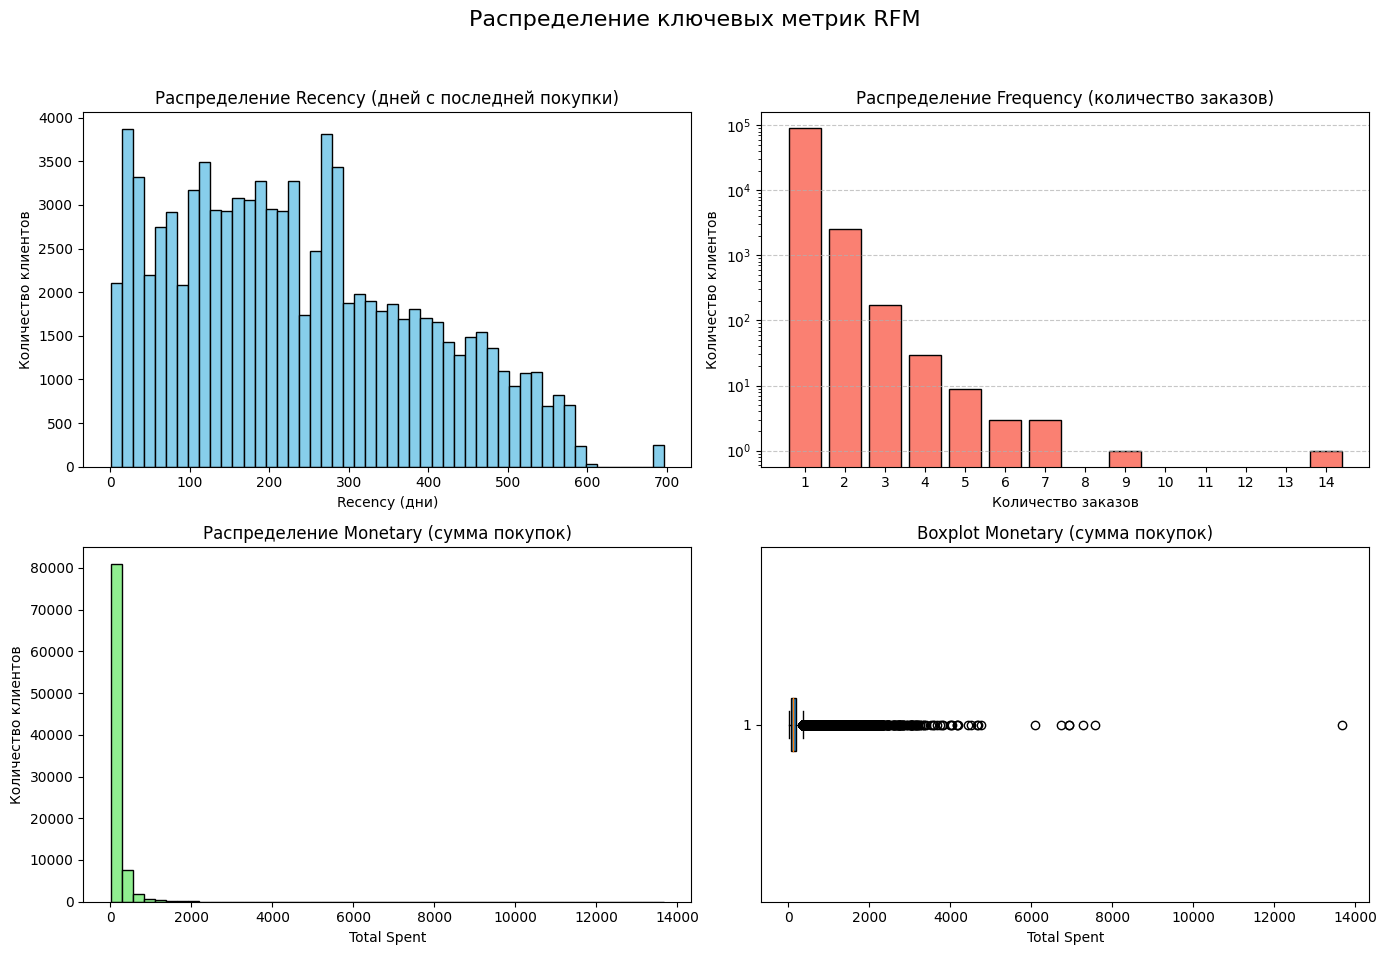

In [31]:
# Вывожу графики распределний
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Распределение ключевых метрик RFM', fontsize=16)

#  Recency
axes[0, 0].hist(rfm['recency'], bins=50, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Распределение Recency (дней с последней покупки)')
axes[0, 0].set_xlabel('Recency (дни)')
axes[0, 0].set_ylabel('Количество клиентов')

# Frequency (num_orders) - ЛОГАРИФМИЧЕСКАЯ ШКАЛА
freq_counts = rfm['num_orders'].value_counts().sort_index()
axes[0, 1].bar(freq_counts.index, freq_counts.values, color='salmon', edgecolor='black')
axes[0, 1].set_title('Распределение Frequency (количество заказов)')
axes[0, 1].set_xlabel('Количество заказов')
axes[0, 1].set_ylabel('Количество клиентов')
# Делаю логарифмическую шкалу по Y, чтобы увидеть клиентов с 2,3,... заказами
axes[0, 1].set_yscale('log')
axes[0, 1].set_xticks(range(1, int(freq_counts.index.max())+1))
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

#Распределение Monetary
axes[1, 0].hist(rfm['total_spent'], bins=50, edgecolor='black', color='lightgreen')
axes[1, 0].set_title('Распределение Monetary (сумма покупок)')
axes[1, 0].set_xlabel('Total Spent')
axes[1, 0].set_ylabel('Количество клиентов')

#Boxplot для Monetary
axes[1, 1].boxplot(rfm['total_spent'], vert=False, patch_artist=True)
axes[1, 1].set_title('Boxplot Monetary (сумма покупок)')
axes[1, 1].set_xlabel('Total Spent')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Проведенный анализ клиентской базы выявил ключевую особенность: 
ПОДАВЛЯЮЩЕЕ БОЛЬШИНСТВО КЛИЕНТОВ (97%) СОВЕРШАЮТ ТОЛЬКО ОДНУ ПОКУПКУ.

При этом наблюдается высокая вариативность в суммах покупок (от 9 до 13 600 ) 
и широкий временной разброс последних заказов (от 1 дня до 2 лет).

ЭТО ОЗНАЧАЕТ, ЧТО:
1. Основная проблема бизнеса — удержание клиентов
2. Существует потенциал для реактивации "спящих" клиентов
3. Небольшая группа постоянных клиентов требует особого внимания

RFM-анализ позволит разделить клиентов на сегменты и разработать 
персонализированные стратегии для каждой группы: от удержания новичков 
до реактивации ценных "спящих" клиентов и поощрения лояльных.

### RFM-анализ: начинаем с Frequency

Ранее мы выявили, что 97% клиентов совершают только одну покупку.
Это критическая мало для роста бизнеса. 

Теперь наша задача — понять:

- КТО эти 3% "возвращенцев"?
- ЧЕМ они отличаются от одноразовых клиентов?
- СКОЛЬКО они тратят?

Предполагаю, что повторные покупатели могут иметь другой паттерн поведения
и приносить непропорционально большую долю выручки

In [32]:
# смотрим средний чек для понимания эффективности каждого заказа
rfm['aov'] = rfm['total_spent'] / rfm['num_orders']

In [33]:
# добавляю флаг повторных покупок для разделения покупателей на две группы - повторный и одноразовых
rfm['repeat_flag'] = np.where(rfm['num_orders'] > 1, 'repeat', 'one_time')
print(f" Кол-во одноразовых: {len(rfm[rfm['repeat_flag']=='one_time'])} покупателей")
print(f" Повторных: {len(rfm[rfm['repeat_flag']=='repeat'])} покупателей")

 Кол-во одноразовых: 89336 покупателей
 Повторных: 2742 покупателей


In [34]:
# Смотрю на топ повторных покупателей по сумме трат
top_repeat = rfm[rfm['repeat_flag'] == 'repeat'].sort_values('total_spent', ascending=False).head(10)
print(top_repeat[['customer_unique_id', 'num_orders', 'total_spent', 'aov']].to_string())

                     customer_unique_id  num_orders  total_spent              aov
78560  da122df9eeddfedc1dc1f5349a1a690c           2      7571.63         3785.815
72146  c8460e4251689ba205045f3ea17884a1           4      4655.91        1163.9775
32449  59d66d72939bc9497e19d89c61a96d5f           2      3559.99         1779.995
84604  eae0a83d752b1dd32697e0e7b4221656           2      2783.01         1391.505
77632  d77aa95864ae5b42160937615628723a           2       2450.1          1225.05
48538  86df00dc5fd68f4dd5d5945ca19f3ed6           3      2400.48           800.16
44340  7b0eaf68a16e4808e5388c67345033c9           2      2340.08          1170.04
39625  6ddbc64bd04d40f7768ff088d94cbeb8           2      2299.66          1149.83
10769  1da09dd64e235e7c2f29a4faff33535c           3       2164.4 721.466666666667
41596  73601b1eec55943e90ce8d61253d5c09           2      2068.68          1034.34


Вывод - Среди повторных покупателей есть как клиенты с очень крупными чеками, так и с минимальными. 

Это все говорит о неоднородности группы повторных покупателей(repeat).

Т.е сама по себе возвращаемость покупателя не гарантирует его ценности

In [35]:
rfm[rfm['repeat_flag'] == 'repeat'].sort_values('total_spent', ascending=False)

,customer_unique_id,num_orders,total_spent,first_order_date,last_order_date,recency,aov,repeat_flag
78560,da122df9eeddfedc1dc1f5349a1a690c,2,7571.63,2017-04-01,2017-04-01,516,3785.815,repeat
72146,c8460e4251689ba205045f3ea17884a1,4,4655.91,2018-08-07,2018-08-08,22,1163.9775,repeat
32449,59d66d72939bc9497e19d89c61a96d5f,2,3559.99,2017-03-02,2017-08-10,385,1779.995,repeat
84604,eae0a83d752b1dd32697e0e7b4221656,2,2783.01,2018-02-01,2018-04-24,128,1391.505,repeat
77632,d77aa95864ae5b42160937615628723a,2,2450.1,2017-08-29,2017-08-29,366,1225.05,repeat
...,...,...,...,...,...,...,...,...
52420,91e59b92e87f627abdab279ea3ab0c87,2,38.78,2018-03-30,2018-03-31,152,19.39,repeat
77569,d753459418d268407f19b64be28e3c5a,2,38.24,2017-01-05,2017-01-05,602,19.12,repeat
89184,f7be9bec658c62ab6240b44cd26c0b84,2,38.24,2017-01-05,2017-01-05,602,19.12,repeat
88036,f497dd3ee9e4ef33b42acd82713e4bf3,2,37.34,2018-06-04,2018-06-04,87,18.67,repeat


Чтобы количественно оценить вклад повторных покупателей в выручку и понять насколько возвращаемость покупателя гарантирует его ценность сравниваю между собой две группы - repeat и one_time

In [36]:
# таблица с нужными метриками
rev_by_group = rfm.groupby('repeat_flag').agg(
    total_revenue=('total_spent', 'sum'),
    customers_count=('customer_unique_id', 'count'),
    arpc=('total_spent', 'mean'), # average revenue per customer - средняя выручка на покупателя
    total_orders=('num_orders', 'sum')
).reset_index()

# Добавляю метрики среднего чека и средней выручки на покупателя
rev_by_group['aov'] = (rev_by_group['total_revenue'] / rev_by_group['total_orders']).round(2)
rev_by_group['rev_share_%'] = (rev_by_group['total_revenue'] / rev_by_group['total_revenue'].sum() * 100).round(1)

display(rev_by_group[['total_revenue', 'customers_count', 'arpc', 'aov', 'rev_share_%']])

,total_revenue,customers_count,arpc,aov,rev_share_%
0,14376722.560000000522,89336,160.92865765201,160.93,94.4
1,848260.609999999986,2742,309.358355215171,146.5,5.6


H₀ (нулевая): средний AOV у repeat = средний AOV у one-time
H₁ (альтернативная): AOV у repeat ниже, чем у one-time

In [37]:
# Делю покупателей на две независимые выборки
one_time_aov = rfm[rfm['repeat_flag'] == 'one_time']['aov']
repeat_aov = rfm[rfm['repeat_flag'] == 'repeat']['aov']

print(f"Группа one_time: n = {len(one_time_aov):,}, "
      f"средний AOV = {one_time_aov.mean():.2f} ₽, "
      f"медиана = {one_time_aov.median():.2f} ₽")
print(f"Группа repeat:   n = {len(repeat_aov):,}, "
      f"средний AOV = {repeat_aov.mean():.2f} ₽, "
      f"медиана = {repeat_aov.median():.2f} ₽")
print(f"Разница средних: {one_time_aov.mean() - repeat_aov.mean():.2f} ₽")

Группа one_time: n = 89,336, средний AOV = 160.93 ₽, медиана = 105.37 ₽
Группа repeat:   n = 2,742, средний AOV = 146.31 ₽, медиана = 110.33 ₽
Разница средних: 14.62 ₽


Проверяю на нормальность распределения выборок  при помощи теста Шапиро-Уилка:

In [40]:
# Тест Шапиро-Уилка (для больших выборок может быть чувствителен)
# Использую подвыборку для теста, так как на полных данных тест всегда покажет ненормальность
one_time_sample = one_time_aov.sample(min(5000, len(one_time_aov)), random_state=42)
repeat_sample = repeat_aov.sample(min(500, len(repeat_aov)), random_state=42)

shapiro_one = stats.shapiro(one_time_sample)
shapiro_repeat = stats.shapiro(repeat_sample)

print(f"One-time Shapiro-Wilk test: statistic={shapiro_one.statistic:.4f}, p-value={shapiro_one.pvalue:.4f}")
print(f"Repeat Shapiro-Wilk test:   statistic={shapiro_repeat.statistic:.4f}, p-value={shapiro_repeat.pvalue:.4f}")

One-time Shapiro-Wilk test: statistic=0.4553, p-value=0.0000
Repeat Shapiro-Wilk test:   statistic=0.3448, p-value=0.0000


Так как обе группы показали p < 0.05, значит данные не нормальны
Учитывая что у нас ненормально распределение, независимые выборки(покупатели никак не влияют друг на друга) используем тест  Манна-Уитни 

In [41]:
mannwhitney_result = stats.mannwhitneyu(one_time_aov, repeat_aov, alternative='two-sided')
print(f"U-статистика: {mannwhitney_result.statistic:.2f}")
print(f"p-value: {mannwhitney_result.pvalue:.10f}")

U-статистика: 116918886.00
p-value: 0.0000499196


In [42]:
print("\nИнтерпретация результатов:")

alpha = 0.05
if mannwhitney_result.pvalue < alpha:
    print(f" p-value = {mannwhitney_result.pvalue:.10f} < {alpha}")
    print("   Отвергаем нулевую гипотезу H₀")
    print("   Обнаружена статистически значимая разница в распределении среднего чека клиента(AOV расчитан на уровне клиента, а не заказа)")


Интерпретация результатов:
 p-value = 0.0000499196 < 0.05
   Отвергаем нулевую гипотезу H₀
   Обнаружена статистически значимая разница в распределении среднего чека клиента(AOV расчитан на уровне клиента, а не заказа)


Несмотря на статистическую значимость, абсолютная разница составляет ~9%, что требует дополнительной оценки практической значимости для бизнеса.

Давайте посмотрим насколько это различие большое:

In [45]:
# размеры выборок
n1 = len(one_time_aov)
n2 = len(repeat_aov)
N = n1 + n2
N

92078

In [47]:
# U-статистика
U = mannwhitney_result.statistic
U

116918886.0

In [49]:
# математическое ожидание U
mean_U = n1 * n2 / 2
mean_U

122479656.0

In [50]:
# стандартное отклонение U
std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
std_U

1370997.4619976508

In [51]:
# Z-значение
Z = (U - mean_U) / std_U
Z

-4.056003132126533

In [52]:
# effect size
r = Z / np.sqrt(N)
r

-0.013366581259133118

In [53]:
print(f"\nZ-статистика: {Z:.4f}")
print(f"Effect size (r): {abs(r):.4f}")


Z-статистика: -4.0560
Effect size (r): 0.0134


In [54]:
if abs(r) < 0.1:
    interpretation = "очень маленький эффект"
elif abs(r) < 0.3:
    interpretation = "маленький эффект"
elif abs(r) < 0.5:
    interpretation = "средний эффект"
else:
    interpretation = "большой эффект"

print(f"Интерпретация: {interpretation}")

Интерпретация: очень маленький эффект


Различие статистически значимо, но эффект крайне маленький

Визуализирую различия между группами в логарифмической шкале(из-за сильного разброса в данных)

/tmp/ipykernel_165210/2240225716.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='repeat_flag', y='aov', ax=axes[2], palette=['#ff9999', '#66b3ff'])


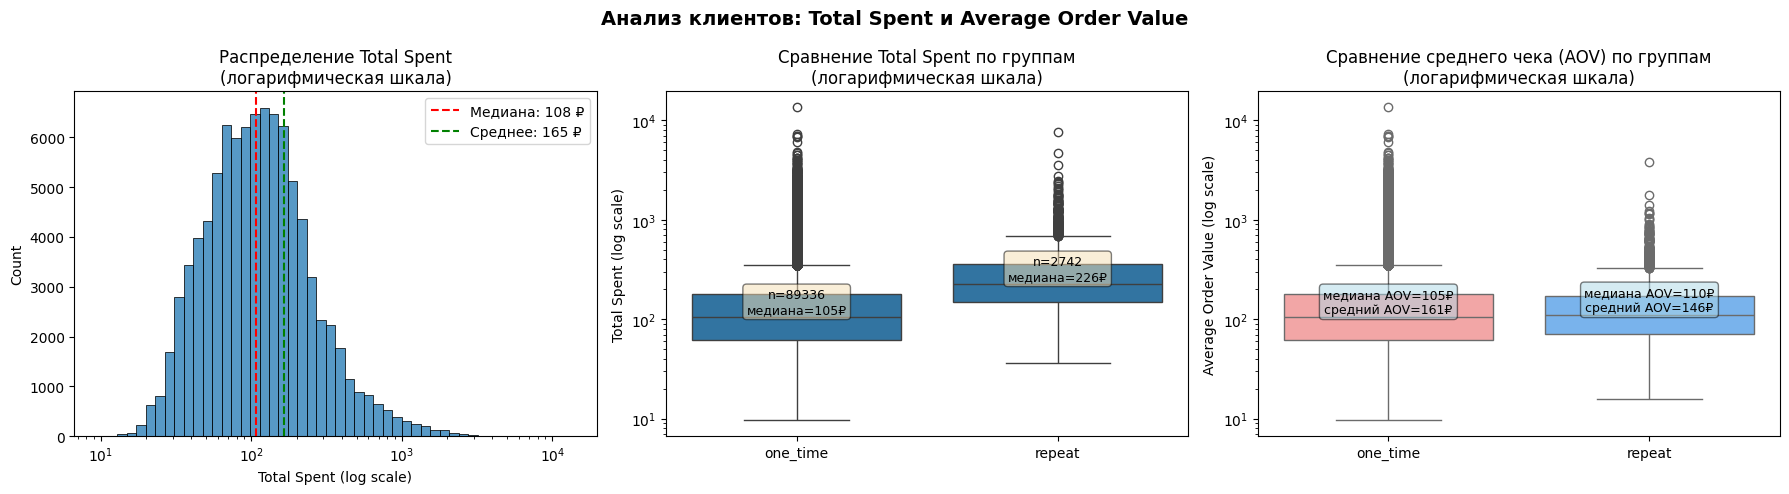

In [55]:
# График распределния по total_spent
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение total_spent
sns.histplot(data=rfm, x='total_spent', bins=50, log_scale=True, ax=axes[0])
axes[0].set_title('Распределение Total Spent\n(логарифмическая шкала)', fontsize=12)
axes[0].set_xlabel('Total Spent (log scale)')
axes[0].axvline(x=rfm['total_spent'].median(), color='red', linestyle='--', label=f'Медиана: {rfm["total_spent"].median():.0f} ₽')
axes[0].axvline(x=rfm['total_spent'].mean(), color='green', linestyle='--', label=f'Среднее: {rfm["total_spent"].mean():.0f} ₽')
axes[0].legend()

# Box plot total_spent по группам
sns.boxplot(data=rfm, x='repeat_flag', y='total_spent', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Сравнение Total Spent по группам\n(логарифмическая шкала)', fontsize=12)
axes[1].set_ylabel('Total Spent (log scale)')
axes[1].set_xlabel('')

#  статистика на boxplot
for i, category in enumerate(['one_time', 'repeat']):
    category_data = rfm[rfm['repeat_flag'] == category]['total_spent']
    axes[1].text(i, category_data.median() * 1.1, 
                f'n={len(category_data)}\nмедиана={category_data.median():.0f}₽', 
                ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Box plot среднего чека (AOV) по группам
sns.boxplot(data=rfm, x='repeat_flag', y='aov', ax=axes[2], palette=['#ff9999', '#66b3ff'])
axes[2].set_yscale('log')
axes[2].set_title('Сравнение среднего чека (AOV) по группам\n(логарифмическая шкала)', fontsize=12)
axes[2].set_ylabel('Average Order Value (log scale)')
axes[2].set_xlabel('')

# статистика boxplot AOV
for i, category in enumerate(['one_time', 'repeat']):
    category_aov = rfm[rfm['repeat_flag'] == category]['aov']
    axes[2].text(i, category_aov.median() * 1.1, 
                f'медиана AOV={category_aov.median():.0f}₽\nсредний AOV={category_aov.mean():.0f}₽', 
                ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle('Анализ клиентов: Total Spent и Average Order Value', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Основные выводы:
- повторные покупатели дают непропорционально высокий вклад, но не настолько критичный, чтобы считать их единственным драйвером роста
- анализ показал что cредний чек  у повторных покупателей НИЖЕ (146₽ против 161₽)  и среди повторных есть как "киты" с чеками >7000₽, так и "микро-покупатели" с чеками <40₽, что свидетельствует что возвращаемость сама по себе не гарантирует высокую ценность, нужно смотреть на комбинацию частоты и суммы покупок.
- повторные покупатели ценнее в долгосрочной перспективе, так как их ARPC выше, но каждый отдельный заказ в среднем дешевле, чем у одноразовых клиентов.

Резюмирую - 

Повторные покупатели составляют 3% базы и дают 5.6% выручки, при этом тратят почти в 2 раза больше за весь период сотрудничества.

Однако возвращаемость НЕ гарантирует ценность: их средний чек на 9% ниже, чем у одноразовых клиентов.


Это значит, что бизнесу нужно работать в двух направлениях:
1) Превращать одноразовых в повторных (работа с частотой)
2) Повышать чек у повторных (работа с суммой)

### RFM-анализ: смотрим Monetary 

Прежде чем углубляться в сложные комбинации с давностью и частотой, нужно понять общую структуру: сколько у нас «массовых» клиентов с низким чеком, а сколько — «элиты», тратящей по-крупному.

Для этого необходимо разделить наших покупателей на сегменты:
- эконом - тратят мало
- срелний класс - тратят средне
- премиум - трятят много
- vip- трятя очень много

Благодаря такой сегментации мы увидим:
- в каких сегментах живут те самые 3% повторных покупателей
- доли сегментов(кого больше, кого меньше и т.д.)
- ответим на вопрос - Правда ли, что повторные покупки — это привилегия премиальных сегментов, или масс-маркет тоже возвращается?
- ответим на вопрос - Работает ли принцип Парето (20% клиентов дают 80% выручки)?
- данная сегментация поможет понять  насколько бизнес зависит от «китов» и уязвим при их оттоке. 

In [56]:
rfm['total_spent'].describe()

count              92078
mean    165.348760507396
std     226.249703284543
min                 9.59
25%                 63.1
50%               107.78
75%               183.03
max             13664.08
Name: total_spent, dtype: float64

Ключевые выводы из статистики:

- Сильный перекос распределения
Среднее (165 ₽) значительно выше медианы (108 ₽). Это классический признак того, что распределение имеет "длинный хвост" справа — есть небольшая группа клиентов с очень высокими тратами, которые "тянут" среднее вверх.

- Медиана — более честный показатель
Типичный клиент тратит около 108 ₽. 

- Квартили рисуют портрет масс-маркета
50% клиентов тратят от 63 до 183 ₽. Это "золотой стандарт" нашей базы — не бедные, но и не богатые.

- Существование "китов"
Max = 13,664 ₽ — это клиент, который заслуживает отдельного изучения. Кто он? Что купил? Почему так много?

Для разделения на сегменты использую квантили.
Обоснование метода сегментации:
1) данные имеют сильный разброс
2) интерпретируемость — сегменты имеют четкий бизнес-смысл:
      - эконом: массовый сегмент, чувствительный к цене
      - средний: ядро клиентской базы
      - премиум: ценные клиенты с высоким чеком
      - vip: элита, приносящая максимум прибыли
3) у нас достаточно данных на разделение именно на 4 сегмента
4) благодаря данному подходу есть возможность выделить именно VIP покупателей и работать с ними в дальнейшем как с отдельной категорией 

In [57]:
# квантили
q25 = rfm['total_spent'].quantile(0.25)
q75 = rfm['total_spent'].quantile(0.75)
q95 = rfm['total_spent'].quantile(0.95)

In [58]:
# функция для разделения на сегменты по квантилям:
def m_segment(row):
    if row['total_spent'] < q25:
        return 'эконом'
    elif row['total_spent'] < q75:
        return 'средний' 
    elif row['total_spent'] < q95:
        return 'премиум'
    else:
        return 'vip'

rfm['m_seg'] = rfm.apply(m_segment, axis=1)

Вывожу график  ниже чтобы оценить как разделились данные на сегменты по monetary и не пересекаются ли границы сегментов:

/tmp/ipykernel_165210/254197141.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box = sns.boxplot(data=rfm, x='m_seg', y='total_spent', order=order, palette=colors)


<Figure size 1200x600 with 0 Axes>

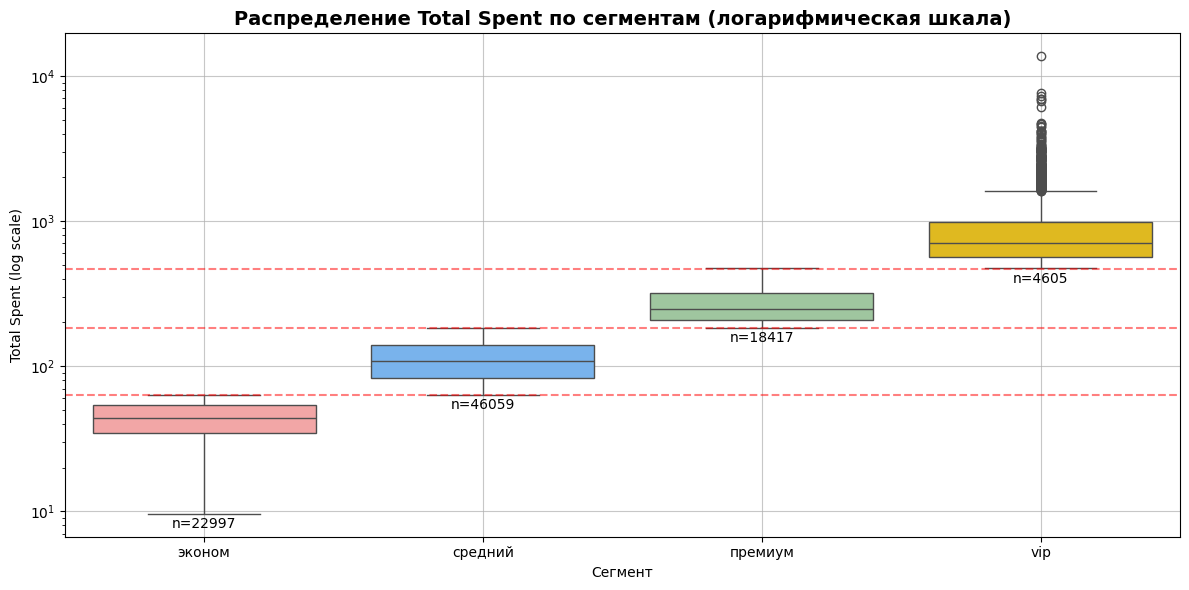

In [59]:
plt.figure(figsize=(12, 6))

# Порядок сегментов
order = ['эконом', 'средний', 'премиум', 'vip']
colors = ['#ff9999', '#66b3ff', '#99cc99', '#ffcc00']

# Box plot
plt.figure(figsize=(12, 6))
box = sns.boxplot(data=rfm, x='m_seg', y='total_spent', order=order, palette=colors)
plt.yscale('log')

# Добавляю горизонтальные линии границ
boundaries = [63.06, 182.56, 469.71]
for b in boundaries:
    plt.axhline(y=b, color='red', linestyle='--', alpha=0.5)

plt.title('Распределение Total Spent по сегментам (логарифмическая шкала)', fontsize=14, fontweight='bold')
plt.xlabel('Сегмент')
plt.ylabel('Total Spent (log scale)')

# Добавляю количество клиентов
for i, seg in enumerate(order):
    count = len(rfm[rfm['m_seg'] == seg])
    plt.text(i, rfm[rfm['m_seg'] == seg]['total_spent'].min() * 0.8, 
             f'n={count}', ha='center', fontsize=10)

plt.grid(True, alpha=0.7)
plt.tight_layout()
plt.show()

На boxplot мы видим, что:

   • Границы сегментов (красные линии) проходят по "естественным" разрывам и не пересекаются между собой
   
   • В каждом сегменте достаточно данных для анализа

   • VIP-сегмент содержит выбросы — это наши самые ценные покупатели
   
   • Логарифмическая шкала позволяет увидеть все сегменты одновременно

Мы разделили покупателей на 4 группы по их денежной ценности (Monetary),
чтобы понять:
1) Кто приносит основную выручку?
2) На каких клиентах фокусировать маркетинговые усилия?
3) Как распределяются клиенты по сегментам?
4) Какой средний чек в каждом сегменте?

Это критически важно для:
- Приоритизации клиентов в маркетинге
   
- Разработки разных стратегий для разных сегментов
   
- Понимания структуры клиентской базы

Для ответа на эти вопросы вывожу график:

In [60]:
# График по m-сегментам
m_seg_stats = rfm.groupby('m_seg').agg({
    'customer_unique_id': 'count',
    'total_spent': 'sum',
    'aov': 'mean'
}).round(2)

m_seg_stats.columns = ['клиенты', 'выручка', 'средний_чек']
m_seg_stats['%_клиентов'] = (m_seg_stats['клиенты'] / len(rfm) * 100).round(1)
m_seg_stats['%_выручки'] = (m_seg_stats['выручка'] / rfm['total_spent'].sum() * 100).round(1)

# Сортирую в логическом порядке
m_order = ['эконом', 'средний', 'премиум', 'vip']
m_seg_stats = m_seg_stats.reindex(m_order)

# Переименовываваю для графика
m_seg_stats.index = ['ЭКОНОМ', 'СРЕДНИЙ', 'ПРЕМИУМ', 'VIP']

In [61]:
m_seg_stats

,клиенты,выручка,средний_чек,%_клиентов,%_выручки
ЭКОНОМ,22997,1002641.119999999995,43.54,25,6.6
СРЕДНИЙ,46059,5170272.370000000112,110.88,50,34
ПРЕМИУМ,18417,4976020.429999999702,259.66,20,32.7
VIP,4605,4076049.25,844.17,5,26.8


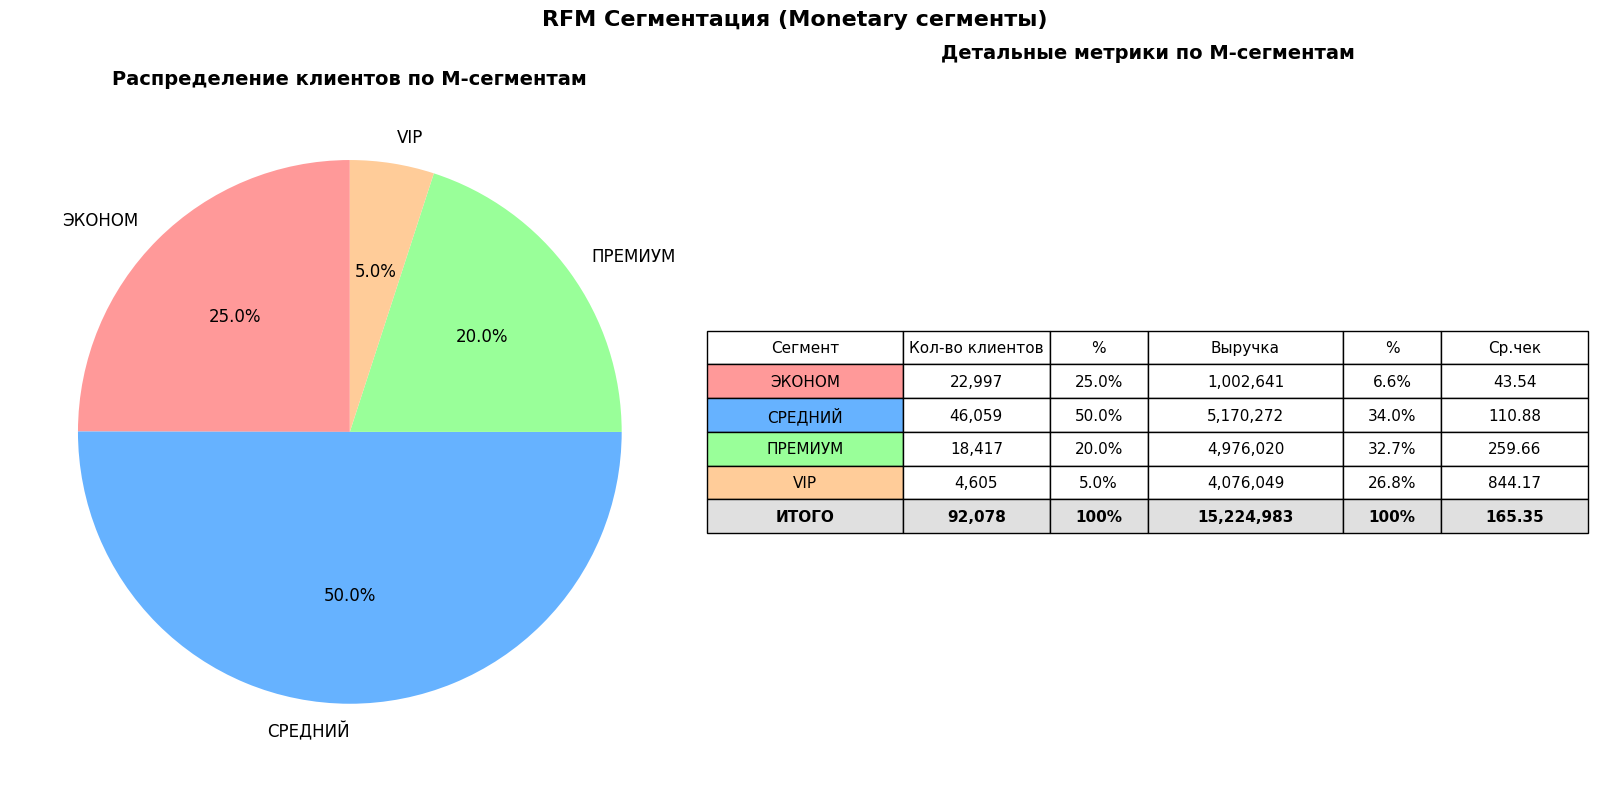

In [62]:
# Создаю график для M-сегментов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), 
                                gridspec_kw={'width_ratios': [1, 1.2]})
m_colors_display = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'] 
wedges, texts, autotexts = ax1.pie(m_seg_stats['клиенты'], 
                                    labels=m_seg_stats.index, 
                                    colors=m_colors_display,
                                    autopct='%1.1f%%', 
                                    startangle=90,
                                    textprops={'fontsize': 12})

ax1.set_title('Распределение клиентов по M-сегментам', 
              fontsize=14, fontweight='bold')

# Таблица
ax2.axis('off')
table_data = []
total_customers = len(rfm)
total_revenue = rfm['total_spent'].sum()

for seg in m_seg_stats.index:
    row = m_seg_stats.loc[seg]
    table_data.append([
        seg,
        f"{row['клиенты']:,.0f}",
        f"{row['%_клиентов']:.1f}%",
        f"{row['выручка']:,.0f}",
        f"{row['%_выручки']:.1f}%",
        f"{row['средний_чек']:.2f}"
    ])

table_data.append([
    'ИТОГО',
    f"{total_customers:,.0f}",
    "100%",
    f"{total_revenue:,.0f}",
    "100%",
    f"{total_revenue/total_customers:.2f}"
])

table = ax2.table(cellText=table_data,
                  colLabels=['Сегмент', 'Кол-во клиентов', '%', 'Выручка', '%', 'Ср.чек'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.2, 0.15, 0.1, 0.2, 0.1, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Раскрашиваю строки
for i in range(len(m_seg_stats)):
    table[(i+1, 0)].set_facecolor(m_colors_display[i])

for col in range(6):
    table[(len(table_data), col)].set_facecolor('#E0E0E0')
    table[(len(table_data), col)].set_text_props(weight='bold')

ax2.set_title('Детальные метрики по M-сегментам', 
              fontsize=14, fontweight='bold', pad=20)

plt.suptitle('RFM Сегментация (Monetary сегменты)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Топ-25% клиентов (ПРЕМИУМ + VIP) приносят 59.5% всей выручки,
при этом их средний чек в 3-19 раз выше массового сегмента.

Принцип Парето работает, но с поправкой — у нас не 20/80, а скорее 25/60. Это все еще огромная концентрация: четверть клиентов формирует почти две трети оборота

Это подтверждает необходимость дифференцированного подхода:

- VIP (5%) — удерживать любыми средствами
- ПРЕМИУМ (20%) — развивать до VIP
- СРЕДНИЙ (50%) — повышать чек
- ЭКОНОМ (25%) — вовлекать, но не переинвестировать

Теперь необходимо понять:

- Как repeat-клиенты распределяются по денежным сегментам?
- В каких сегментах концентрация повторных покупок выше?
- Какой вклад repeat-клиенты вносят в выручку каждого сегмента?
- Есть ли связь между суммой покупки и вероятностью возврата?

Ответы на данные вопросы позвоялт понять на каких именно покупателей в приоритете   тратить маркетинговый бюджет чтобы получить максимальный возврат


In [63]:
# Определяю порядок сегментов (от меньшего к большему)
order = ['эконом', 'средний', 'премиум', 'vip']
colors = ['#ff9999', '#66b3ff', '#99cc99', '#ffcc00']
explode = (0, 0, 0.1, 0.2)  # Смещаю премиум и VIP 

In [64]:
print("Сегменты в порядке возрастания ценности:", order)

Сегменты в порядке возрастания ценности: ['эконом', 'средний', 'премиум', 'vip']


In [65]:
# Считаю количество клиентов в каждом сегменте
segment_counts = rfm['m_seg'].value_counts()
segment_counts = segment_counts.reindex(order)
print(f"\nРаспределение клиентов:\n{segment_counts}")


Распределение клиентов:
m_seg
эконом     22997
средний    46059
премиум    18417
vip         4605
Name: count, dtype: int64


In [66]:
# Считаю выручку по сегментам
segment_revenue = rfm.groupby('m_seg')['total_spent'].sum()
segment_revenue = segment_revenue.reindex(order)
print(f"\nВыручка по сегментам:\n{segment_revenue}")


Выручка по сегментам:
m_seg
эконом    1002641.119999999995
средний   5170272.370000000112
премиум   4976020.429999999702
vip                 4076049.25
Name: total_spent, dtype: float64


In [67]:
# Рассчитываю процент repeat-покупателей в каждом сегменте
repeat_pct_values = []
for seg in order:
    total = len(rfm[rfm['m_seg'] == seg])
    repeat = len(rfm[(rfm['m_seg'] == seg) & (rfm['repeat_flag'] == 'repeat')])
    pct = (repeat / total * 100) if total > 0 else 0
    repeat_pct_values.append(pct)
    print(f"  • {seg}: {repeat} repeat из {total} клиентов ({pct:.1f}%)")

  • эконом: 48 repeat из 22997 клиентов (0.2%)
  • средний: 965 repeat из 46059 клиентов (2.1%)
  • премиум: 1308 repeat из 18417 клиентов (7.1%)
  • vip: 421 repeat из 4605 клиентов (9.1%)


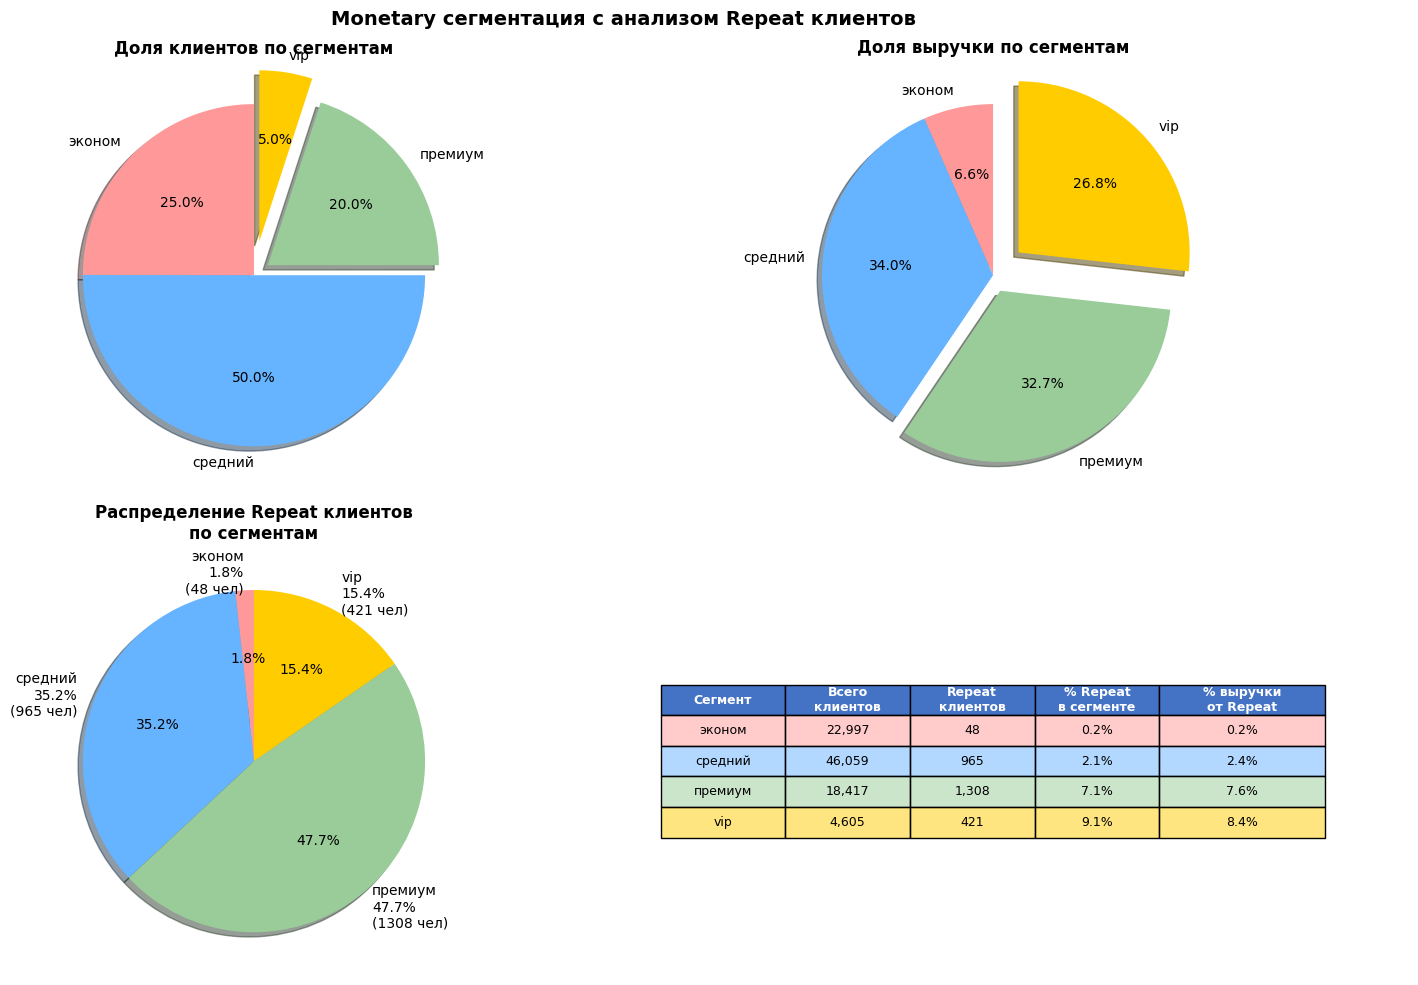

In [69]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
# 1. Круговая диаграмма - доля клиентов
ax1 = fig.add_subplot(gs[0, 0])
wedges1, texts1, autotexts1 = ax1.pie(segment_counts, 
                                       labels=segment_counts.index,
                                       colors=colors,
                                       explode=explode,
                                       autopct='%1.1f%%',
                                       shadow=True,
                                       startangle=90)
ax1.set_title('Доля клиентов по сегментам', fontsize=12, fontweight='bold')

# 2. Круговая диаграмма - доля выручки
ax2 = fig.add_subplot(gs[0, 1])
wedges2, texts2, autotexts2 = ax2.pie(segment_revenue,
                                       labels=segment_revenue.index,
                                       colors=colors,
                                       explode=explode,
                                       autopct='%1.1f%%',
                                       shadow=True,
                                       startangle=90)
ax2.set_title('Доля выручки по сегментам', fontsize=12, fontweight='bold')

# 3. Круговая диаграмма - распределение repeat-клиентов
ax3 = fig.add_subplot(gs[1, 0])

# Данные по Repeat
repeat_counts = rfm[rfm['repeat_flag'] == 'repeat']['m_seg'].value_counts()
repeat_counts = repeat_counts.reindex(order).fillna(0)

# Нормирую до 100% для круговой
repeat_pie_data = repeat_counts / repeat_counts.sum() * 100

# Создаем подписи с процентами и количеством
repeat_labels = [f'{seg}\n{repeat_pie_data[seg]:.1f}%\n({int(repeat_counts[seg])} чел)' 
                 for seg in order if repeat_counts[seg] > 0]
repeat_data = [repeat_pie_data[seg] for seg in order if repeat_pie_data[seg] > 0]
repeat_colors = [colors[i] for i in range(len(order)) if repeat_pie_data[order[i]] > 0]

wedges3, texts3, autotexts3 = ax3.pie(repeat_data,
                                       labels=repeat_labels,
                                       colors=repeat_colors,
                                       autopct='%1.1f%%',
                                       shadow=True,
                                       startangle=90)
ax3.set_title('Распределение Repeat клиентов\nпо сегментам', fontsize=12, fontweight='bold')

# 4. Таблица с детальной информацией
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Создаю таблицу с процентами repeat и их вкладом в выручку
table_data = []
for seg in order:
    total = len(rfm[rfm['m_seg'] == seg])
    repeat = len(rfm[(rfm['m_seg'] == seg) & (rfm['repeat_flag'] == 'repeat')])
    pct = (repeat / total * 100) if total > 0 else 0
    
    # Добавляем информацию о выручке от Repeat
    total_rev = rfm[rfm['m_seg'] == seg]['total_spent'].sum()
    repeat_rev = rfm[(rfm['m_seg'] == seg) & (rfm['repeat_flag'] == 'repeat')]['total_spent'].sum()
    rev_pct = (repeat_rev / total_rev * 100) if total_rev > 0 else 0
    
    table_data.append([seg, f'{total:,}', f'{repeat:,}', f'{pct:.1f}%', f'{rev_pct:.1f}%'])

table = ax4.table(cellText=table_data, 
                  colLabels=['Сегмент', 'Всего\nклиентов', 'Repeat\nклиентов', '% Repeat\nв сегменте', '% выручки\nот Repeat'],
                  cellLoc='center', loc='center', colWidths=[0.15, 0.15, 0.15, 0.15, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Раскрашиваю строки в цвета сегментов
for i in range(len(order)):
    for j in range(5):
        table[(i+1, j)].set_facecolor(colors[i] + '80')  # '80' добавляет прозрачность

# Выделяю заголовок таблицы
for j in range(5):
    table[(0, j)].set_facecolor('#4472c4')
    table[(0, j)].set_text_props(weight='bold', color='white')

plt.suptitle('Monetary сегментация с анализом Repeat клиентов', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


82.9% всех повторных покупателей в СРЕДНЕМ и ПРЕМИУМ сегментах.

При этом:
• ЭКОНОМ (25% базы) → лишь 1.8% repeat
• VIP (5% базы) → 15.4% repeat (но их мало)

ВЫВОД - Работа с лояльностью должна фокусироваться на "золотой середине" — 
клиентах со средним и выше среднего чеком. Именно там максимальный 
потенциал для превращения одноразовых покупателей в постоянных.

### RMF: Анализ Recency

Мы уже проанализировали сколько тратят покупатели  и увидели, что премиальные сегменты формируют основную выручку. 
Однако не  менее важно понимать, **когда клиенты совершали последнюю покупку**, для того чтобы:

- оценить текущую активность базы. Чем больше времени прошло с последней покупки, тем выше вероятность, что клиент потерян навсегда
- подготовить данные для комбинированной сегментации (R*M), которая даст полный портрет клиента.
- ответить на вопрос- есть ли связь между денежной составляющей покупателя и давностью его покупки?
- ответить на вопрос - какой процент базы — лояльные, а сколько — потерянные/спящие? Это критически важно для планирования реактивационных кампаний.
- ответить на вопрос -  есть ли связь между денежной ценностью и давностью покупки? Возможно, VIP-клиенты возвращаются быстрее?

In [70]:
rfm['recency'].describe()

count              92078
mean    237.793121049545
std     152.582089471279
min                    1
25%                  114
50%                  219
75%                  346
max                  696
Name: recency, dtype: float64

Ключевые выводы из статистики:
- Критически высокая медиана (219 дней)
- Огромный разброс (от 1 до 696 дней)
- Активных клиентов критически мало. Даже лучшие 25% клиентов (1-й квартиль) покупали в среднем 114 дней назад 
- Максимум почти 2 года. Наличие клиентов с давностью > 600 дней говорит о том, что компания не чистит базу и не реактивирует "мертвые души".

In [71]:
# Создаю группы
bins = [0, 30, 90, 180, 365, 700]
# labels = ['0-30\n(горячие)', '31-90\n(теплые)', '91-180\n(прохладные)', 
#           '181-365\n(холодные)', '365+\n(спящие)']

labels = ['свежие', 'остывающие', 'на_грани', 
           'спящие', 'потерянные']

In [72]:
print(f"""
   Границы сегментов:
   • 0-30 дней    → свежие (активные)
   • 31-90 дней   → остывающие (нуждаются в прогеве)
   • 91-180 дней  → на грани (риск потери)
   • 181-365 дней → спящие (нужна реактивация)
   • 365+ дней    → потерянные (высокий риск ухода)
""")


   Границы сегментов:
   • 0-30 дней    → свежие (активные)
   • 31-90 дней   → остывающие (нуждаются в прогеве)
   • 91-180 дней  → на грани (риск потери)
   • 181-365 дней → спящие (нужна реактивация)
   • 365+ дней    → потерянные (высокий риск ухода)



In [73]:
rfm['r_seg'] = pd.cut(rfm['recency'], bins=bins, labels=labels)

In [74]:
# Таблица распределения
recency_table = pd.DataFrame({
    'Группа': labels,
    'Покупателей': rfm['r_seg'].value_counts().sort_index().values,
    '%': (rfm['r_seg'].value_counts(normalize=True).sort_index().values * 100).round(1)
})

# СОРТИРУЮ по убыванию количества покупателей
recency_table_sorted = recency_table.sort_values('Покупателей', ascending=False)

print("\nРАСПРЕДЕЛЕНИЕ ПО RECENCY:")
print(recency_table_sorted.to_string(index=False))


РАСПРЕДЕЛЕНИЕ ПО RECENCY:
    Группа  Покупателей    %
    спящие        33974 36.9
потерянные        20430 22.2
  на_грани        19381   21
остывающие        11707 12.7
    свежие         6586  7.2


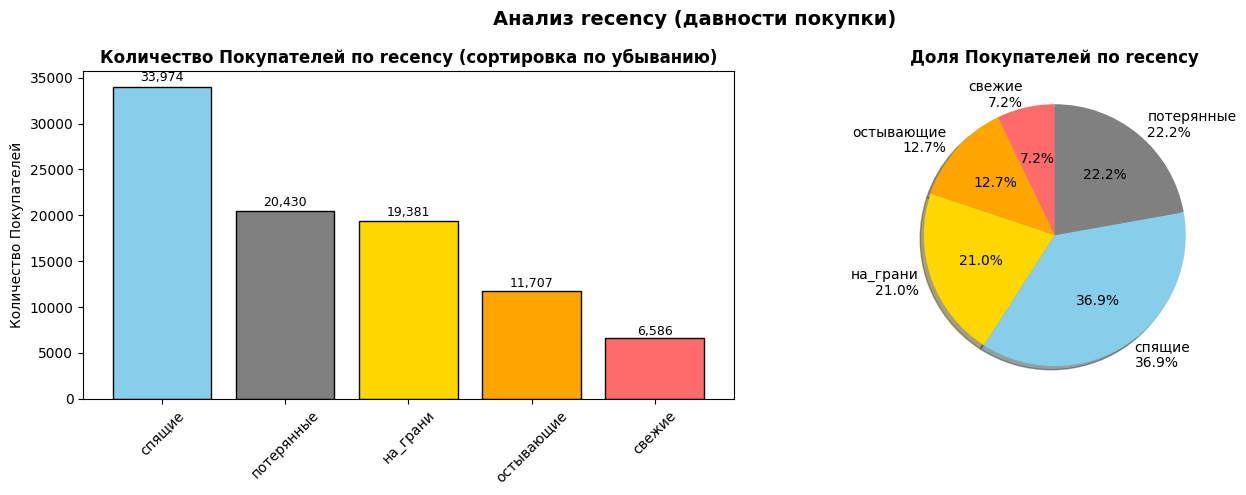

In [75]:
# График распределения по recency
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Словарь цветов для каждого сегмента (фиксированное соответствие)
color_dict = {
    'свежие': '#ff6b6b',      # красный
    'остывающие': '#ffa500',    # оранжевый
    'на_грани': '#ffd700',      # желтый
    'спящие': '#87ceeb',        # голубой
    'потерянные': '#808080'     # серый
}

# Столбчатая диаграмма с сохранением цветов сегментов
bars = ax1.bar(recency_table_sorted['Группа'], recency_table_sorted['Покупателей'], 
               color=[color_dict[group] for group in recency_table_sorted['Группа']], 
               edgecolor='black')
ax1.set_title('Количество Покупателей по recency (сортировка по убыванию)', 
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Количество Покупателей')
ax1.tick_params(axis='x', rotation=45)

# Добавляю значения
for bar, count in zip(bars, recency_table_sorted['Покупателей']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Круговая диаграмма (порядок цветов соответствует исходному порядку групп)
colors_for_pie = [color_dict[group] for group in recency_table['Группа']]
ax2.pie(recency_table['Покупателей'], 
        labels=[f'{l}\n{v:.1f}%' for l, v in zip(recency_table['Группа'], recency_table['%'])],
        colors=colors_for_pie, autopct='%1.1f%%', startangle=90, shadow=True)
ax2.set_title('Доля Покупателей по recency', fontsize=12, fontweight='bold')

plt.suptitle('Анализ recency (давности покупки)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [76]:
# Вывожу сводную таблицу по всем метрикам:
metrics_df = pd.DataFrame()

for seg in ['эконом', 'средний', 'премиум', 'vip']:
    seg_data = rfm[rfm['m_seg'] == seg]
    
    metrics = {
        'Сегмент': seg,
        'Количество клиентов': len(seg_data),
        'Доля клиентов': f"{len(seg_data)/len(rfm)*100:.1f}%",
        'Общая выручка': seg_data['total_spent'].sum(),
        'Доля выручки': f"{seg_data['total_spent'].sum()/rfm['total_spent'].sum()*100:.1f}%",
        'Средний чек': seg_data['total_spent'].mean(),
        'Медианный чек': seg_data['total_spent'].median(),
        'Средняя давность': seg_data['recency'].mean()
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])])

print("\nСВОДНАЯ ТАБЛИЦА МЕТРИК ПО СЕГМЕНТАМ")
print("="*125)
print(metrics_df.to_string(index=False))


СВОДНАЯ ТАБЛИЦА МЕТРИК ПО СЕГМЕНТАМ
Сегмент  Количество клиентов Доля клиентов        Общая выручка Доля выручки      Средний чек  Медианный чек  Средняя давность
 эконом                22997         25.0% 1002641.120000000112         6.6%   43.59877897117          44.01  239.575205461582
средний                46059         50.0% 5170272.370000000112        34.0% 112.253248442215         107.78   237.94698104605
премиум                18417         20.0% 4976020.429999999702        32.7% 270.186264321008         246.92  236.009664983439
    vip                 4605          5.0%           4076049.25        26.8%  885.13555917481         701.85  234.487296416938


Вывлд - Только 7.2% клиентов активны (покупали в последний месяц)
80% клиентов — в зоне риска (не покупали от 3 месяцев до года)
22% клиентов — потеряны навсегда (не покупали больше года)

ПРИ ЭТОМ: денежная ценность НЕ ВЛИЯЕТ на лояльность.
VIP-клиенты уходят так же быстро, как и эконом.

ВЫВОД:
Нужна срочная система удержания для ВСЕХ сегментов,
с фокусом на реактивацию "спящих" (36.9% базы)

# Итоговая RM-сегментация: комбинация  monetary и recency 

Мы уже проанализировали по отдельности:
- Monetary (сколько тратят) — 4 сегмента: эконом, средний, премиум, vip
- Recency (когда покупали) — 5 сегментов: свежие, остывающие, на_грани, спящие, потерянные

ТЕПЕРЬ МЫ ОБЪЕДИНЯЕМ ИХ, чтобы получить:
   4 × 5 = 20 уникальных комбинаций клиентов

ЭТО ПОЗВОЛЯЕТ ОТВЕТИТЬ НА ВОПРОСЫ:

1) Какие комбинации M × R приносят больше всего выручки?
2) В каких сегментах самая высокая доля повторных покупок?
3) Где сосредоточены наши самые ценные клиенты?
4) Какие сегменты требуют срочного вмешательства?


In [77]:
# базовый сегмент 
rfm['base_seg'] = rfm['m_seg'].astype(str) + '_' + rfm['r_seg'].astype(str)

#  статистика
quick_stats = rfm.groupby('base_seg').agg(
    клиентов=('customer_unique_id', 'count'),
    выручка=('total_spent', 'sum'),
    средний_чек=('aov', 'mean'),
    repeat=('repeat_flag', lambda x: (x == 'repeat').sum()),
    доля_repeat=('repeat_flag', lambda x: (x == 'repeat').mean() * 100)
).round(2)

# Добавляю проценты
quick_stats['%_клиентов'] = (quick_stats['клиентов'] / len(rfm) * 100).round(1)
quick_stats['%_выручки'] = (quick_stats['выручка'] / rfm['total_spent'].sum() * 100).round(1)

# Сортирую по выручке
quick_stats = quick_stats.sort_values('выручка', ascending=False)

unique_segments = rfm['base_seg'].nunique()
print(f"Создано {unique_segments} уникальных сегментов (4×5=20 возможных)")


print("ИТОГОВАЯ СЕГМЕНТАЦИЯ M x R:")
display(quick_stats[['клиентов', '%_клиентов', 'выручка', '%_выручки', 
                     'средний_чек', 'repeat', 'доля_repeat']].head(15))

Создано 20 уникальных сегментов (4×5=20 возможных)
ИТОГОВАЯ СЕГМЕНТАЦИЯ M x R:


,клиентов,%_клиентов,выручка,%_выручки,средний_чек,repeat,доля_repeat
base_seg,,,,,,,
средний_спящие,17060,18.5,1907693.100000000093,12.5,110.35,381,2.23
премиум_спящие,6808,7.4,1846320.939999999944,12.1,260.17,506,7.43
vip_спящие,1615,1.8,1394354.689999999944,9.2,822.39,151,9.35
средний_потерянные,10246,11.1,1135855.209999999963,7.5,109.66,191,1.86
средний_на_грани,9688,10.5,1096730.219999999972,7.2,111.86,198,2.04
премиум_потерянные,3953,4.3,1073601.020000000019,7.1,263.66,217,5.49
премиум_на_грани,3947,4.3,1059784.669999999925,7,257.56,290,7.35
vip_на_грани,1061,1.2,942521.959999999963,6.2,844.06,109,10.27
vip_потерянные,969,1.1,882584.670000000042,5.8,882.11,60,6.19


Топ-3 сегмента по выручке — все из категории "спящие"! 


ИТОГОВАЯ ТАБЛИЦА С % REPEAT (сортировка по выручке):


,клиенты,%_клиентов,выручка,%_выручки,средний_чек,%_repeat
base_seg,,,,,,
vip_на_грани,1061,1.2,942521.959999999963,6.2,844.06,10.27
vip_остывающие,650,0.7,580248.359999999986,3.8,843.26,10.92
vip_потерянные,969,1.1,882584.670000000042,5.8,882.11,6.19
vip_свежие,310,0.3,276339.570000000007,1.8,841.33,9.68
vip_спящие,1615,1.8,1394354.689999999944,9.2,822.39,9.35
премиум_на_грани,3947,4.3,1059784.669999999925,7,257.56,7.35
премиум_остывающие,2436,2.6,655909.920000000042,4.3,257.73,7.84
премиум_потерянные,3953,4.3,1073601.020000000019,7.1,263.66,5.49
премиум_свежие,1273,1.4,340403.880000000005,2.2,254.65,8.17


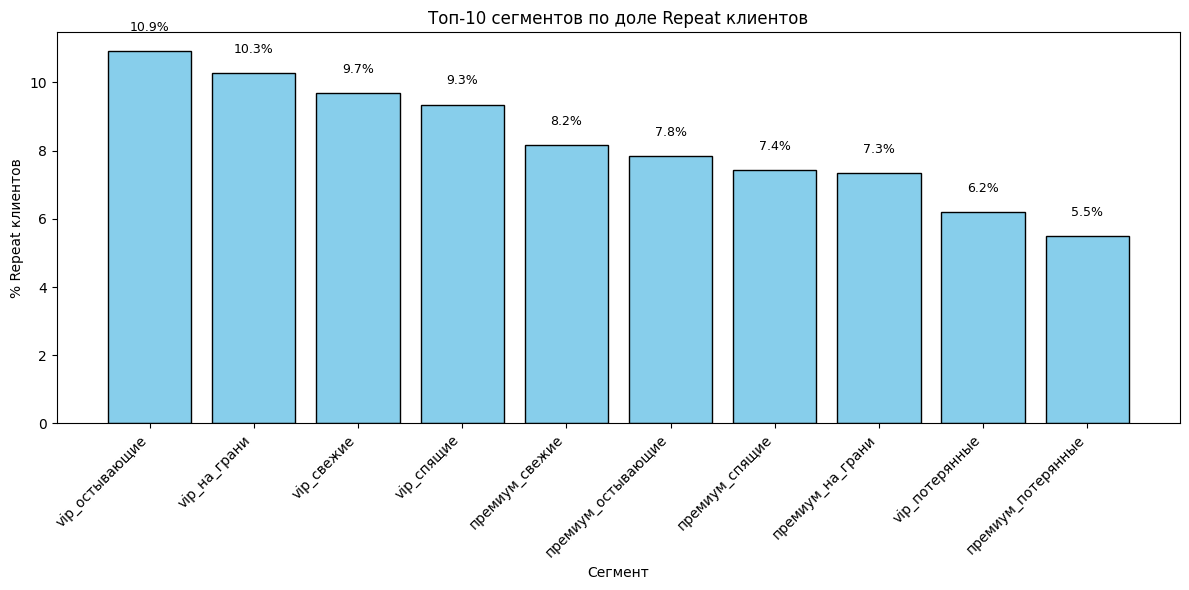

In [78]:
# Создаю итоговую таблицу для графика
final_stats = rfm.groupby('base_seg').agg({
    'customer_unique_id': 'count',
    'total_spent': 'sum',
    'aov': 'mean',
    'repeat_flag': lambda x: (x == 'repeat').mean() * 100
}).round(2)

final_stats.columns = ['клиенты', 'выручка', 'средний_чек', '%_repeat']
final_stats['%_клиентов'] = (final_stats['клиенты'] / len(rfm) * 100).round(1)
final_stats['%_выручки'] = (final_stats['выручка'] / rfm['total_spent'].sum() * 100).round(1)

# вывожу таблицу, отсортированную по выручке
print("ИТОГОВАЯ ТАБЛИЦА С % REPEAT (сортировка по выручке):")
display(final_stats[['клиенты', '%_клиентов', 'выручка', '%_выручки', 
                     'средний_чек', '%_repeat']].head(15))

# сортирую по проценту повторных клиентов
final_stats_for_chart = final_stats.sort_values('%_repeat', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

# Барчарт с процентом Repeat 
top10 = final_stats_for_chart.head(10)
x = range(len(top10))
bars = ax.bar(x, top10['%_repeat'], color='skyblue', edgecolor='black')
ax.set_xlabel('Сегмент')
ax.set_ylabel('% Repeat клиентов')
ax.set_title('Топ-10 сегментов по доле Repeat клиентов')
ax.set_xticks(x)
ax.set_xticklabels(top10.index, rotation=45, ha='right')

# Добавляю значения
for bar, val in zip(bars, top10['%_repeat']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Вывод по графику:

Топ по repeat — это ВСЕ сегменты VIP и ПРЕМИУМ, причем независимо от recency!
   
- vip_остывающие: 10.9% repeat (самые лояльные)
- vip_на_грани: 10.3% repeat
- vip_свежие: 9.7% repeat
   
Лояльность определяется деньгами, а не свежестью. 

Богатые клиенты возвращаются чаще, даже если давно не покупали.

ПРОБЛЕМА: 90% премиум-клиентов не возвращаются → НУЖНА СИСТЕМА УДЕРЖАНИЯ

In [79]:
# Группирую для визуализации
base_stats = rfm.groupby('base_seg').agg({
    'customer_unique_id': 'count',
    'total_spent': 'sum',
    'aov': 'mean'
}).round(2)

base_stats.columns = ['клиенты', 'выручка', 'средний_чек']
base_stats['%_клиентов'] = (base_stats['клиенты'] / len(rfm) * 100).round(1)
base_stats['%_выручки'] = (base_stats['выручка'] / rfm['total_spent'].sum() * 100).round(1)
base_stats = base_stats.sort_values('выручка', ascending=False)

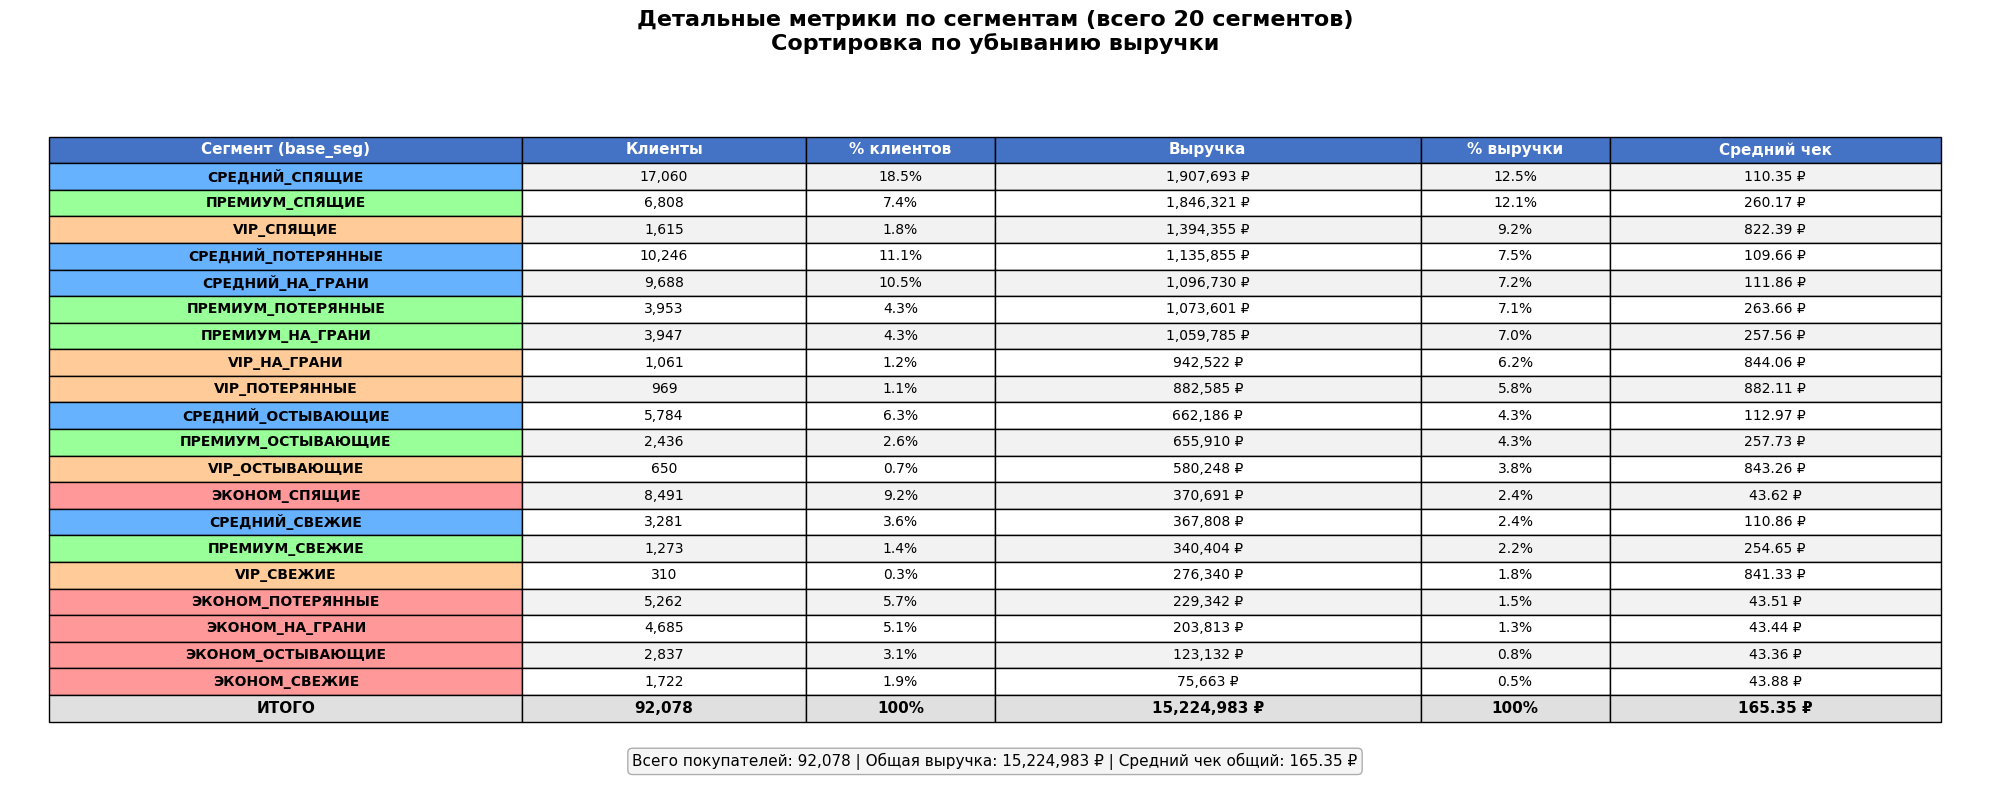

In [82]:
# Создаем отдельную фигуру для таблицы base_seg
fig_base = plt.figure(figsize=(20, 8))  
ax_base = fig_base.add_subplot(111)
ax_base.axis('off')


# Функция для получения цвета по M-сегменту
def get_color_for_segment(seg_name):
    m_part = seg_name.split('_')[0]
    color_map = {
        'эконом': '#FF9999',
        'средний': '#66B2FF',
        'премиум': '#99FF99',
        'vip': '#FFCC99'
    }
    return color_map.get(m_part, '#808080')

colors_for_base = [get_color_for_segment(seg) for seg in base_stats.index]

# Подготовка данных для таблицы base_seg
base_table_data = []

for idx, row in base_stats.iterrows():
    base_table_data.append([
        idx.upper(), 
        f"{row['клиенты']:,.0f}", 
        f"{row['%_клиентов']:.1f}%",  
        f"{row['выручка']:,.0f} ₽",  
        f"{row['%_выручки']:.1f}%",  
        f"{row['средний_чек']:.2f} ₽"  
    ])

total_customers = len(rfm)
total_revenue = rfm['total_spent'].sum()

base_table_data.append([
    'ИТОГО',
    f"{total_customers:,.0f}",
    "100%",
    f"{total_revenue:,.0f} ₽",
    "100%",
    f"{total_revenue/total_customers:.2f} ₽"
])

# Создаю таблицу base_seg
base_table = ax_base.table(cellText=base_table_data,
                          colLabels=['Сегмент (base_seg)', 'Клиенты', '% клиентов', 
                                    'Выручка', '% выручки', 'Средний чек'],
                          cellLoc='center',
                          loc='center',
                          colWidths=[0.20, 0.12, 0.08, 0.18, 0.08, 0.14])

base_table.auto_set_font_size(False)
# Динамический размер шрифта в зависимости от количества строк
font_size = max(8, min(12, 12 - (len(base_stats) // 10)))
base_table.set_fontsize(font_size)
base_table.scale(1.2, 1.4)

# Стилизация таблицы base_seg
# Заголовок
for j in range(6):
    base_table[(0, j)].set_facecolor('#4472c4')
    base_table[(0, j)].set_text_props(weight='bold', color='white', fontsize=font_size+1)

# Раскрашиваею строки сегментов
for i in range(len(base_stats)):
    # Раскрашиваем первую колонку (название сегмента)
    base_table[(i+1, 0)].set_facecolor(colors_for_base[i])
    base_table[(i+1, 0)].set_text_props(weight='bold')
    
    # Чередование цветов для остальных колонок
    for j in range(1, 6):
        if i % 2 == 0:
            base_table[(i+1, j)].set_facecolor('#f2f2f2')
        else:
            base_table[(i+1, j)].set_facecolor('#ffffff')

# Раскрашиваею итоговую строку
for col in range(6):
    base_table[(len(base_table_data), col)].set_facecolor('#E0E0E0')
    base_table[(len(base_table_data), col)].set_text_props(weight='bold', fontsize=font_size+1)

# Добавляю заголовок
ax_base.set_title(f'Детальные метрики по сегментам (всего {len(base_stats)} сегментов)\n'
                  f'Сортировка по убыванию выручки', 
                  fontsize=16, fontweight='bold', pad=20)

# Добавляею подпись с общей статистикой
total_stats_text = f"Всего покупателей: {total_customers:,.0f} | Общая выручка: {total_revenue:,.0f} ₽ | Средний чек общий: {total_revenue/total_customers:.2f} ₽"
ax_base.text(0.5, 0.02, total_stats_text, 
            transform=ax_base.transAxes, 
            ha='center', fontsize=11, 
            bbox=dict(boxstyle='round', facecolor='#E0E0E0', alpha=0.3))

plt.tight_layout()
plt.show()

В результате проведенного RFM-анализа мы получили полную картину клиентской базы:
1) КЛЮЧЕВАЯ ПРОБЛЕМА — НИЗКАЯ ЛОЯЛЬНОСТЬ:
   • 97% клиентов совершают только 1 покупку
   • 80% клиентов находятся в зоне риска (не покупали более 3 месяцев)
   • 22% клиентов потеряны навсегда (не покупали больше года)

2) ДЕНЕЖНАЯ СТРУКТУРА:
   • Эконом (25% базы) → 6.6% выручки (средний чек 43₽)
   • Средний (50% базы) → 34% выручки (средний чек 111₽)
   • Премиум (20% базы) → 32.7% выручки (средний чек 260₽)
   • VIP (5% базы) → 26.8% выручки (средний чек 844₽)

3) ГЛАВНЫЙ НЮАНС:
   Самые прибыльные сегменты — "СПЯЩИЕ" (средний_спящие, премиум_спящие, vip_спящие)

4) ПОЛУЧЕНО 20 СЕГМЕНТОВ — ГОТОВАЯ ОСНОВА ДЛЯ ТАРГЕТИРОВАННЫХ КОММУНИКАЦИЙ:
   • Мы знаем, кто сколько тратит
   • Мы знаем, когда покупали в последний раз
   • Мы знаем, какой у клиентов средний чек

Мы уже знаем, КОГДА покупали и СКОЛЬКО тратили.
Но для персонализированных рассылок нужно понимать,ЧТО ИМЕННО покупали клиенты в каждом сегменте чтобы сделать таргетинговые рассылки более точными.
Поэтому ниже проанализирую на какие товарные категории у какого сегмента есть спрос.

# Какой сегмент что покупает

In [83]:
df

,order_id,date,customer_unique_id,payment_value,product_id,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,38.71,87285b34884572647811a353c7ac498a,housewares
1,128e10d95713541c87cd1a2e48201934,2017-08-15,3a51803cc0d012c3b5dc8b7528cb05f7,37.77,87285b34884572647811a353c7ac498a,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,ef0996a1a279c26e7ecbd737be23d235,37.77,87285b34884572647811a353c7ac498a,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,e781fdcc107d13d865fc7698711cc572,44.09,87285b34884572647811a353c7ac498a,housewares
4,6ea2f835b4556291ffdc53fa0b3b95e8,2017-11-24,3e4fd73f1e86b135b9b121d6abbe9597,356.12,be021417a6acb56b9b50d3fd2714baa8,housewares
...,...,...,...,...,...,...
108629,9fa3a005f89a187501fa1bd63d6125fb,2017-10-08,f979a07fc18b2af3780a796ba14b96f4,54.09,57bdf3098169cccdb62221bd3e089cbd,fashion_childrens_clothes
108631,3da4b0f0c89bb8fee8a810459e641414,2017-06-08,1f83c87997168e248ea52ad3453b069f,118.96,28ac6af4008a402e5039f3e042a36e13,fashion_childrens_clothes
108632,ee86b68eb9222b0cad7da50f4f758a35,2017-05-17,1b553902a5bbe6ee54a3aaa7cbfb6816,124.52,0ab3ab3b2869073aa9afe795fe9151aa,fashion_childrens_clothes
108633,2c4ada2e75c2ad41dd93cebb5df5f023,2017-01-26,d8bee9ec375c3a0f9ef8ed7456a51dcd,209.06,6c7a0a349ad11817745e3ad58abd5c79,security_and_services


In [84]:
# Джойним таблицы: исходные данные о покупках + информация о сегментах
data = pd.merge(df[['customer_unique_id','product_category_name_english']],
                                rfm[['customer_unique_id', 'base_seg']], 
                                on='customer_unique_id', 
                                how='inner'
                                )

In [85]:
data

,customer_unique_id,product_category_name_english,base_seg
0,7c396fd4830fd04220f754e42b4e5bff,housewares,средний_спящие
1,7c396fd4830fd04220f754e42b4e5bff,baby,средний_спящие
2,3a51803cc0d012c3b5dc8b7528cb05f7,housewares,эконом_потерянные
3,ef0996a1a279c26e7ecbd737be23d235,housewares,эконом_потерянные
4,e781fdcc107d13d865fc7698711cc572,housewares,эконом_спящие
...,...,...,...
95121,f979a07fc18b2af3780a796ba14b96f4,fashion_childrens_clothes,эконом_спящие
95122,1f83c87997168e248ea52ad3453b069f,fashion_childrens_clothes,средний_потерянные
95123,1b553902a5bbe6ee54a3aaa7cbfb6816,fashion_childrens_clothes,средний_потерянные
95124,d8bee9ec375c3a0f9ef8ed7456a51dcd,security_and_services,премиум_потерянные


In [86]:
# Проверка и удаление дубликатов
duplicates = data.duplicated().sum()
print(f"\nНайдено дубликатов: {duplicates}")

if duplicates > 0:
    data = data.drop_duplicates()
    print(f"Дубликаты удалены. Осталось записей: {len(data):,}")


Найдено дубликатов: 1459
Дубликаты удалены. Осталось записей: 93,667


In [87]:
print(f"Всего категорий: {data['product_category_name_english'].nunique()}")
print(f"Всего сегментов: {data['base_seg'].nunique()}")
print(f"Всего клиентов: {data['customer_unique_id'].nunique()}")

Всего категорий: 71
Всего сегментов: 20
Всего клиентов: 92078


In [88]:
print(data['product_category_name_english'].value_counts().head(10))

product_category_name_english
bed_bath_table           8916
health_beauty            8460
sports_leisure           7287
computers_accessories    6384
furniture_decor          6149
housewares               5681
watches_gifts            5394
telephony                4036
auto                     3767
toys                     3753
Name: count, dtype: int64


In [89]:
# Строю сводную таблицу: строки - категории товаров, столбцы - сегменты
pivot_counts = pd.crosstab(data['product_category_name_english'], data['base_seg'])
pivot_counts['Всего'] = pivot_counts.sum(axis=1)
pivot_counts_sorted = pivot_counts.sort_values('Всего', ascending=False)

display(pivot_counts_sorted.head(10))

base_seg,vip_на_грани,vip_остывающие,vip_потерянные,vip_свежие,vip_спящие,премиум_на_грани,премиум_остывающие,премиум_потерянные,премиум_свежие,премиум_спящие,средний_на_грани,средний_остывающие,средний_потерянные,средний_свежие,средний_спящие,эконом_на_грани,эконом_остывающие,эконом_потерянные,эконом_свежие,эконом_спящие,Всего
product_category_name_english,,,,,,,,,,,,,,,,,,,,,
bed_bath_table,45,38,29,19,69,335,216,498,96,614,1073,703,1202,368,2054,320,177,332,99,629,8916
health_beauty,101,96,106,63,140,355,286,305,170,525,998,726,747,371,1521,367,339,443,195,606,8460
sports_leisure,55,30,61,12,94,350,162,281,74,598,815,380,928,236,1609,321,184,364,127,606,7287
computers_accessories,51,23,76,12,131,286,121,250,83,606,829,373,500,185,1159,264,195,509,124,607,6384
furniture_decor,42,25,43,14,56,312,204,306,111,464,786,336,865,175,1271,160,82,441,66,390,6149
housewares,38,48,25,24,62,265,213,210,104,290,560,405,645,267,789,342,233,457,194,510,5681
watches_gifts,161,102,124,30,222,399,217,227,107,650,756,518,242,224,762,96,84,143,51,279,5394
telephony,30,30,5,17,20,45,52,68,74,194,142,64,240,37,298,557,247,665,125,1126,4036
auto,56,37,50,16,78,214,110,139,66,289,423,248,298,160,578,215,185,171,125,309,3767


Далее смотрим не на абсолютные числа, а на ДОЛИ внутри каждого сегмента.
Это позволяет понять, какие категории ПЕРЕДПОЧТИТЕЛЬНЫ для разных групп клиентов.

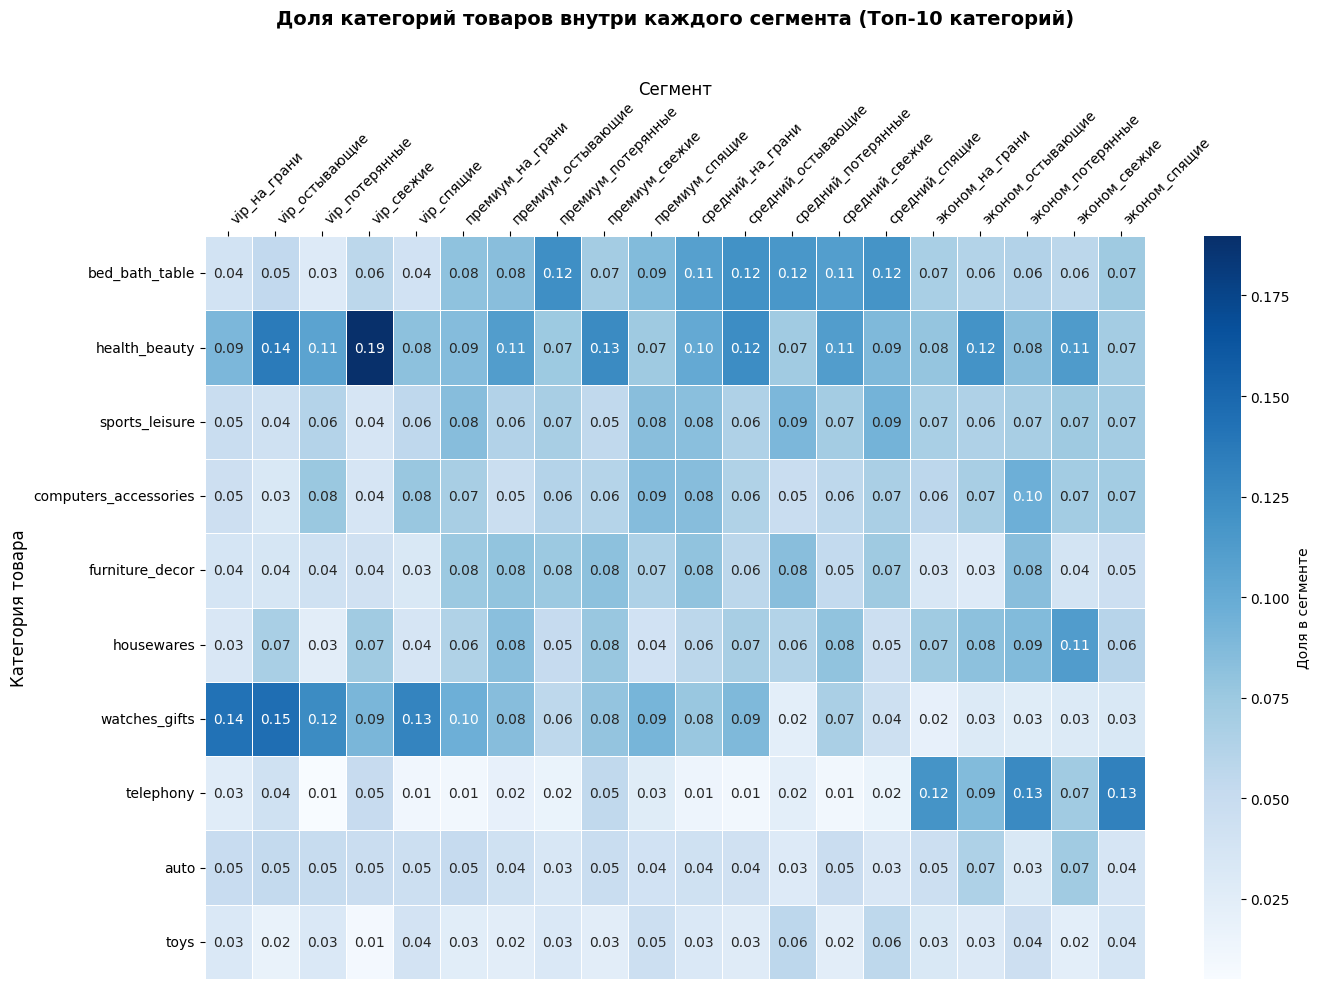

In [90]:
#Визуализация долей категорий внутри сегментов
data_for_heatmap = pd.crosstab(data['product_category_name_english'], data['base_seg'], normalize='columns')
top_categories = data['product_category_name_english'].value_counts().head(10).index
data_for_heatmap_top = data_for_heatmap.loc[top_categories]


plt.figure(figsize=(14, 10))
ax = sns.heatmap(data_for_heatmap_top, annot=True, fmt='.2f', cmap='Blues', linewidths=0.5,
                 cbar_kws={'label': 'Доля в сегменте'})
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left') 
plt.yticks(rotation=0)
plt.title('Доля категорий товаров внутри каждого сегмента (Топ-10 категорий)', 
          fontsize=14, fontweight='bold', pad=40)
plt.ylabel('Категория товара', fontsize=12)
plt.xlabel('Сегмент', fontsize=12)
plt.tight_layout()
plt.show()

Благодаря визуализации выше, можно сделать следующие выводы:

1) Эти категории можно предлагать ВСЕМ сегментам в массовых рассылках :
- bed_bath_table — лидер во всех сегментах, особенно в среднем и эконом
- health_beauty — стабильно высокая доля во всех группах
- sports_leisure — равномерно популярен
   
2) При работе с VIP делаем акцент на часах, подарках и компьютерных аксессуарах.:

3) Телефоны и аксессуары — основной драйвер эконом-сегмента.
       
4)  По давности покупки:
- vip_свежие чаще покупают watches_gifts и health_beauty
- vip_спящие больше склонны к computers_accessories
- средний_свежие активны в bed_bath_table и health_beauty
   


# Стратегии увеличения выручки 

Проведенный RFM-анализ позволил не просто разделить клиентов на группы, но и выявить ключевые проблемы и точки роста. 
Главная проблема — чрезвычайно низкий уровень удержания клиентов при высокой концентрации выручки в небольшой группе "спящих" премиальных покупателей.

На основе полученных 20 сегментов можно сформировать следующие стратегии:

1) Срочная реактивация "спящих гигантов" (Сегменты: средний_спящие, премиум_спящие, vip_спящие ).
   
- Как вариант  запустить email- или push-кампанию с персональными предложениями.


- Для VIP и Премиум — эксклюзивные скидки или ранний доступ к новинкам (особенно в категориях watches_gifts и computers_accessories).

- Для среднего сегмента — выгодные предложения на популярные товары (bed_bath_table, health_beauty).

2) Удержание "свежих" и "теплых" ценных клиентов (Сегменты: vip_свежие, премиум_свежие, vip_остывающие, премиум_остывающие).

- Внедрить программу лояльности для премиальных клиентов. Предложить им подписку с бонусами, кэшбэком или подарками за повторные покупки.


3) Повышение чека в массовых сегментах (Сегменты: средний_на_грани, средний_потерянные, эконом_).

   
- Например, при покупке аксессуаров для телефонов (популярных в экономе) предлагать чехлы премиум-класса или защитные стекла.

4) Трансформация одноразовых клиентов в повторных (Вся база).
   
- Можно  первой покупки отправлять письмо с благодарностью и персональной скидкой на следующий заказ.